In [118]:
%load_ext autoreload
%autoreload 2

In [263]:

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import NearMiss
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc

def plot_learning_curve(model, chart_title, features, targets, score_limits=None, cross_val_method=None, n_jobs=None, data_points=np.linspace(0.1, 1.0, 5)):
    # Set up the plot
    plt.figure(figsize=(8, 6))
    plt.title(chart_title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    if score_limits is not None:
        plt.ylim(score_limits)
    
    sample_sizes, training_scores, validation_scores = learning_curve(
        model, features, targets, cv=cross_val_method, n_jobs=n_jobs, train_sizes=data_points
    )

    mean_training_scores = np.mean(training_scores, axis=1)
    std_training_scores = np.std(training_scores, axis=1)
    mean_validation_scores = np.mean(validation_scores, axis=1)
    std_validation_scores = np.std(validation_scores, axis=1)
    

    plt.grid(True, linestyle='--')
    plt.fill_between(sample_sizes, mean_training_scores - std_training_scores, mean_training_scores + std_training_scores, alpha=0.1, color="#FFA07A")
    plt.fill_between(sample_sizes, mean_validation_scores - std_validation_scores, mean_validation_scores + std_validation_scores, alpha=0.1, color="#20B2AA")
    plt.plot(sample_sizes, mean_training_scores, 'o-', color="#FF6347", label="Training Accuracy")
    plt.plot(sample_sizes, mean_validation_scores, 'o-', color="#3CB371", label="Validation Accuracy")
    
    # Add a legend and show the plot
    plt.legend(loc="lower right")
    plt.show()
    return plt

def plot_validation_curve(data_features, data_target, classifier, model_type): 
    if model_type == 'svm':
        hyperparameter_values = [0.01, 0.1, 1, 10,70,100]
        hyperparameter = 'C'
    elif model_type == 'decision tree':
        hyperparameter_values = np.arange(1, 10)
        hyperparameter = 'max_depth'
    elif model_type == 'knn':
        hyperparameter_values = np.arange(1, 20)
        hyperparameter = 'n_neighbors'
    elif model_type == 'neural network':
        hyperparameter_values = [ 1e-03, 1e-02, 1e-01, 1]
        hyperparameter = 'alpha'
    elif model_type == 'boosted decision tree':
        hyperparameter_values = np.arange(10, 200,15)
        hyperparameter = 'n_estimators'

    train_scores, val_scores = validation_curve(
        classifier, data_features, data_target, 
        param_name=hyperparameter, param_range=hyperparameter_values, 
        cv=5, scoring="accuracy", n_jobs=1
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    mean_val_scores = np.mean(val_scores, axis=1)
    std_val_scores = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title("Validation Curve: " + model_type)
    plt.xlabel(hyperparameter)
    plt.ylabel("Accuracy Score")
    plt.ylim(0.0, 1.1)
    plt.grid(True)
    line_width = 2
    plt.plot(hyperparameter_values, mean_train_scores, 'o-', color="red", lw=line_width, label="Training score")
    plt.fill_between(hyperparameter_values, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, color="red", alpha=0.2, lw=line_width)
    plt.plot(hyperparameter_values, mean_val_scores, 's-', color="blue", lw=line_width, label="Cross-validation score")
    plt.fill_between(hyperparameter_values, mean_val_scores - std_val_scores, mean_val_scores + std_val_scores, color="blue", alpha=0.2, lw=line_width)
    plt.legend(loc="lower right")
    plt.show()


In [264]:
n_cpu = os.cpu_count()
n_thread = n_cpu*2

In [265]:
df = pd.read_csv("/Users/davis901/Desktop/GT/Supervised_Learning/CS7641/data/bank_personal_loan.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Customer         5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [266]:
df.describe()

,ID_Customer,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [267]:
# df.drop(['ID_Customer'], axis=1, inplace=True)
df.Experience = df.Experience.replace(-1, 1)
df.Experience = df.Experience.replace(-2, 2)
df.Experience = df.Experience.replace(-3, 1)
df.head()

,ID_Customer,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [268]:
zipnoise = df[df['ZIP Code'] == 9307]
df.drop(zipnoise.index,inplace=True)

<Axes: >

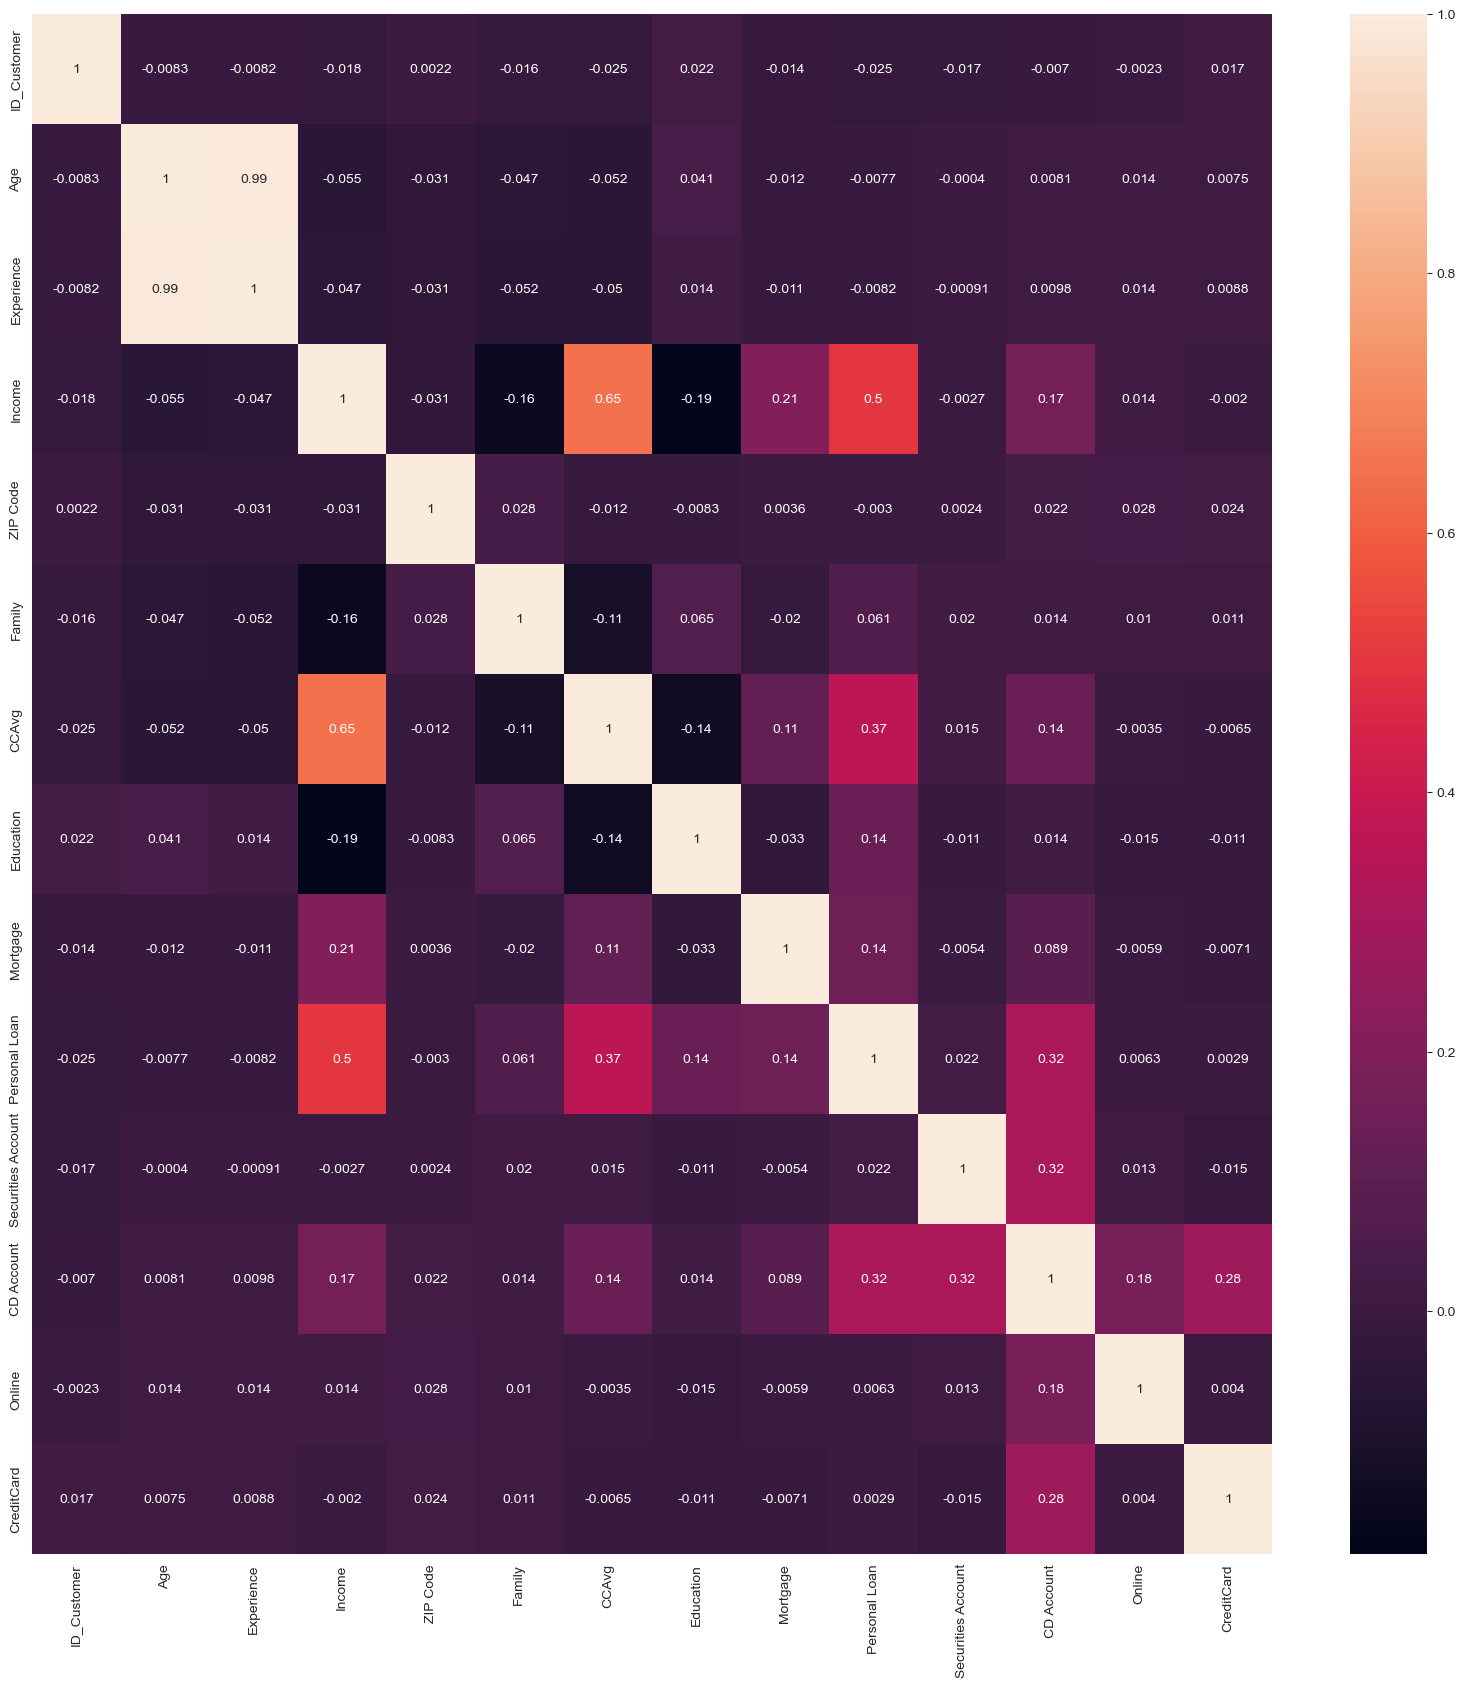

In [269]:
sns.heatmap(df.corr(), annot=True)

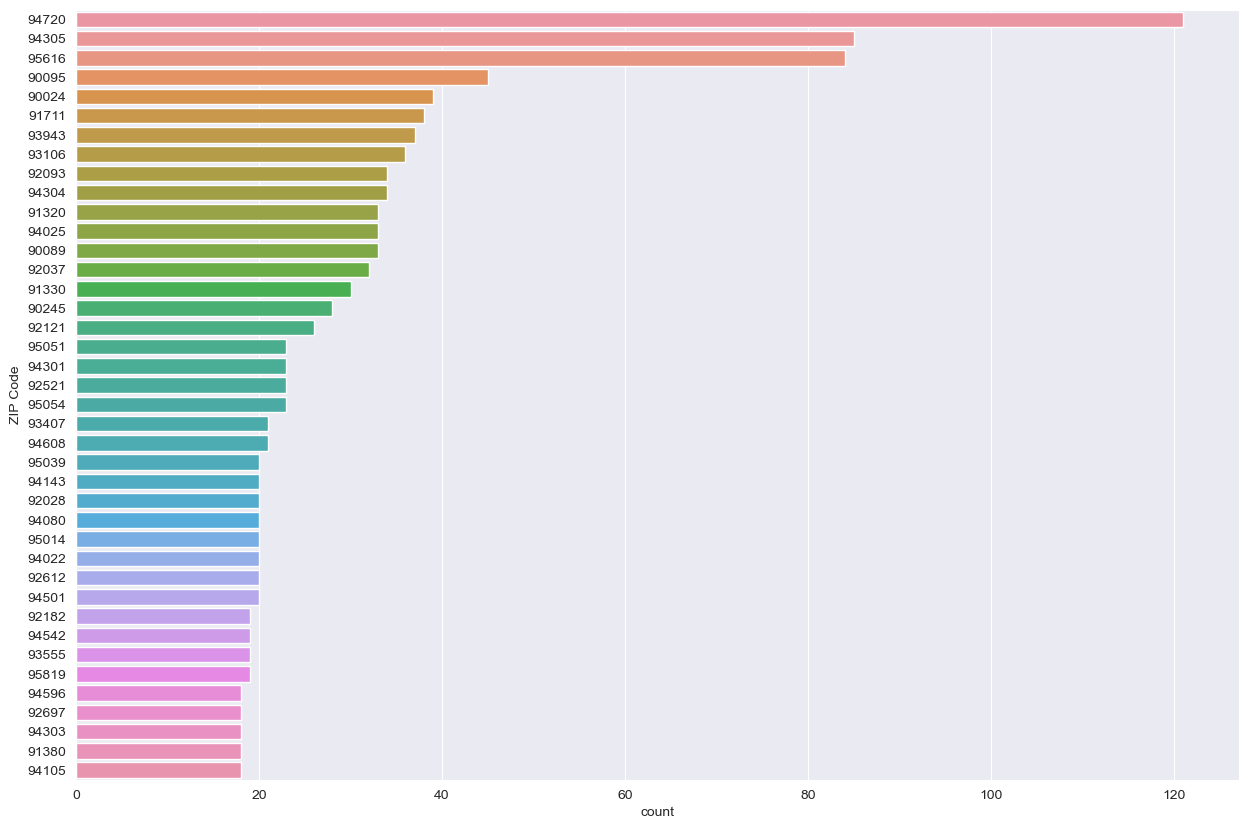

In [270]:
plt.figure(figsize=(15, 10))
sns.countplot(y=df[df.Mortgage==0]['ZIP Code'], 
              data=df, 
              order=df[df.Mortgage==0]['ZIP Code'].value_counts().index[:40]);

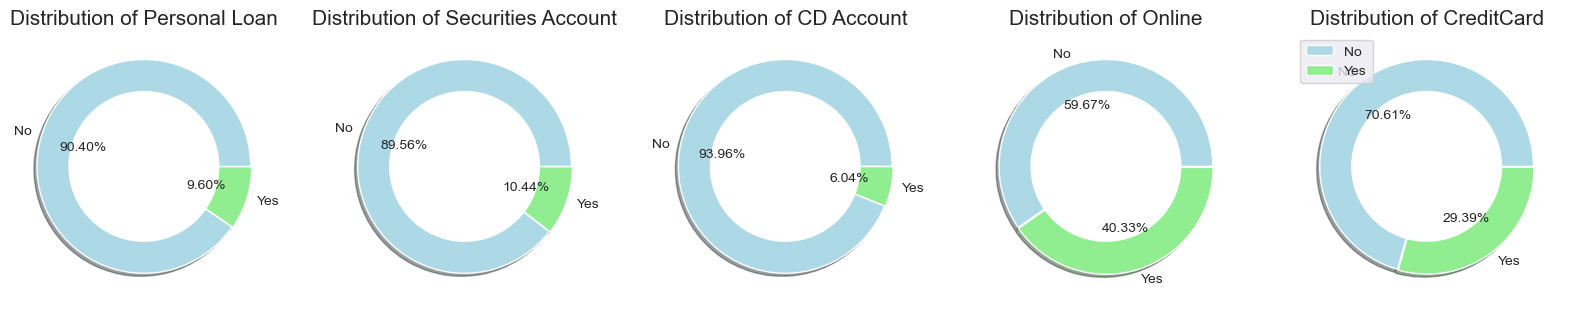

In [271]:
fig, ax = plt.subplots(1,5,figsize=(20,20))
columns = ['Personal Loan','Securities Account','CD Account','Online','CreditCard']

for i,column in enumerate(columns):
    plt.subplot(1,5,i+1)
    size = df[column].value_counts()
    colors = ['lightblue', 'lightgreen']
    labels = "No", "Yes"
    explode = [0, 0.01]

    my_circle = plt.Circle((0, 0), 0.7, color = 'white')

    plt.rcParams['figure.figsize'] = (20, 20)
    plt.pie(size, colors = colors, labels = labels, shadow = True, explode = explode, autopct = '%.2f%%')
    plt.title('Distribution of {}'.format(column), fontsize = 15)
    p = plt.gcf()
    p.gca().add_artist(my_circle)
plt.legend()
plt.show()

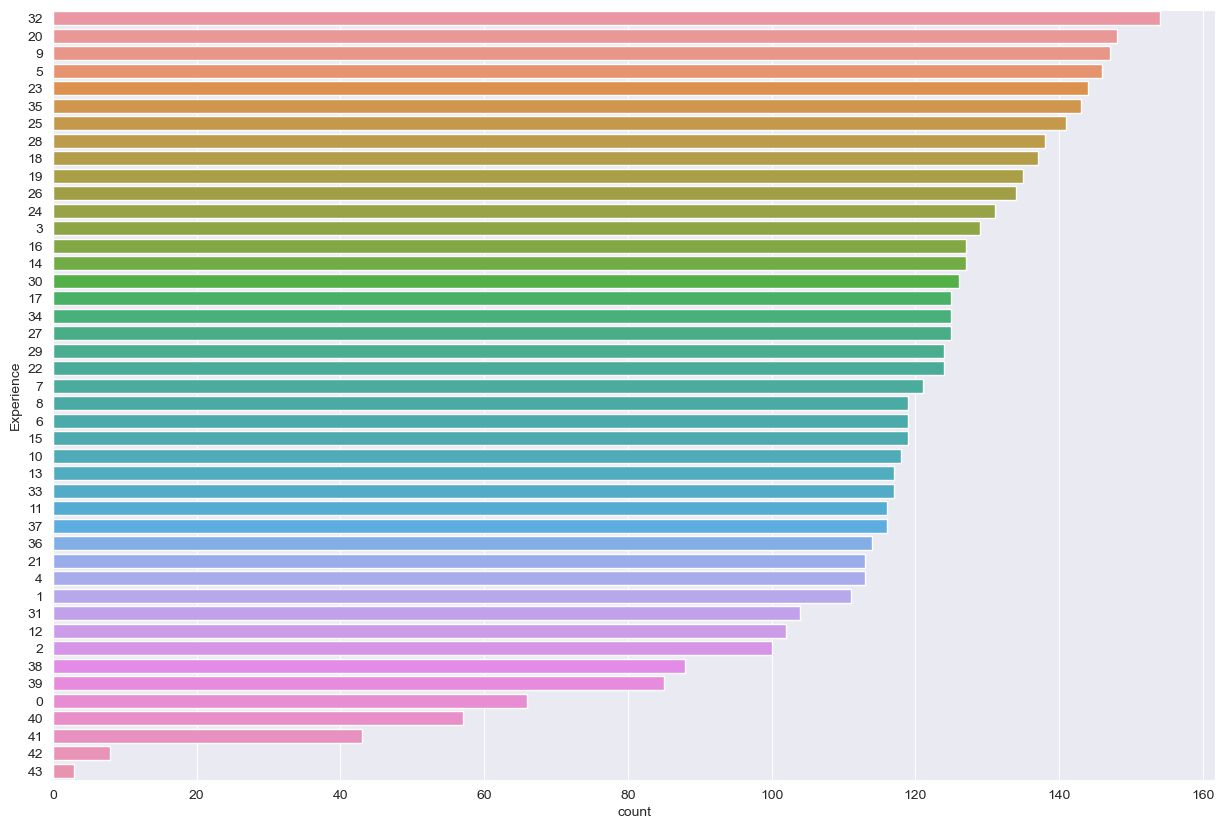

In [272]:
plt.figure(figsize=(15, 10))
sns.countplot(y=df.Experience, 
              data=df, 
              order=df.Experience.value_counts().index[:]);

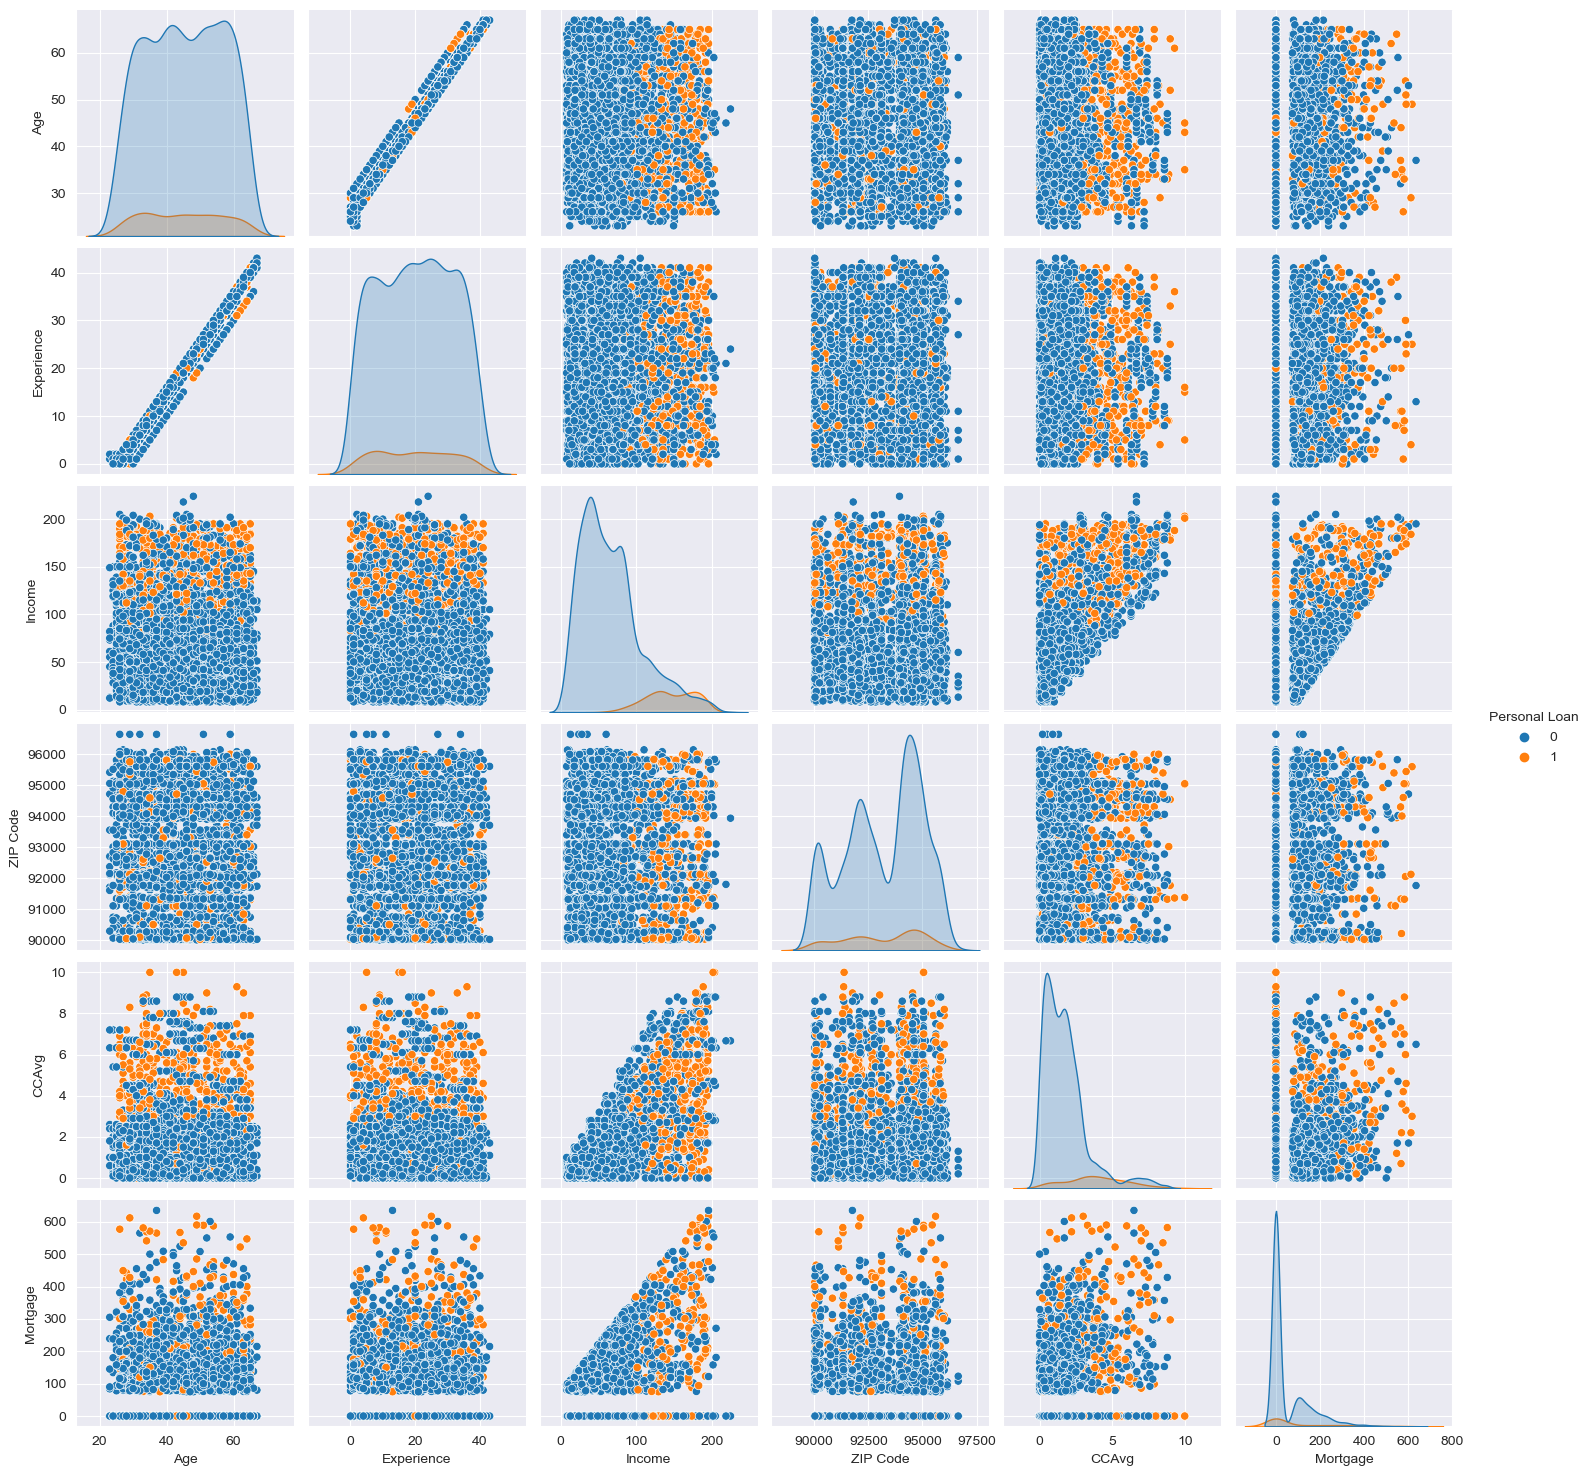

In [273]:
sns.pairplot(data=df[['Age','Experience','Income','ZIP Code','CCAvg','Mortgage','Personal Loan']], 
             hue='Personal Loan');

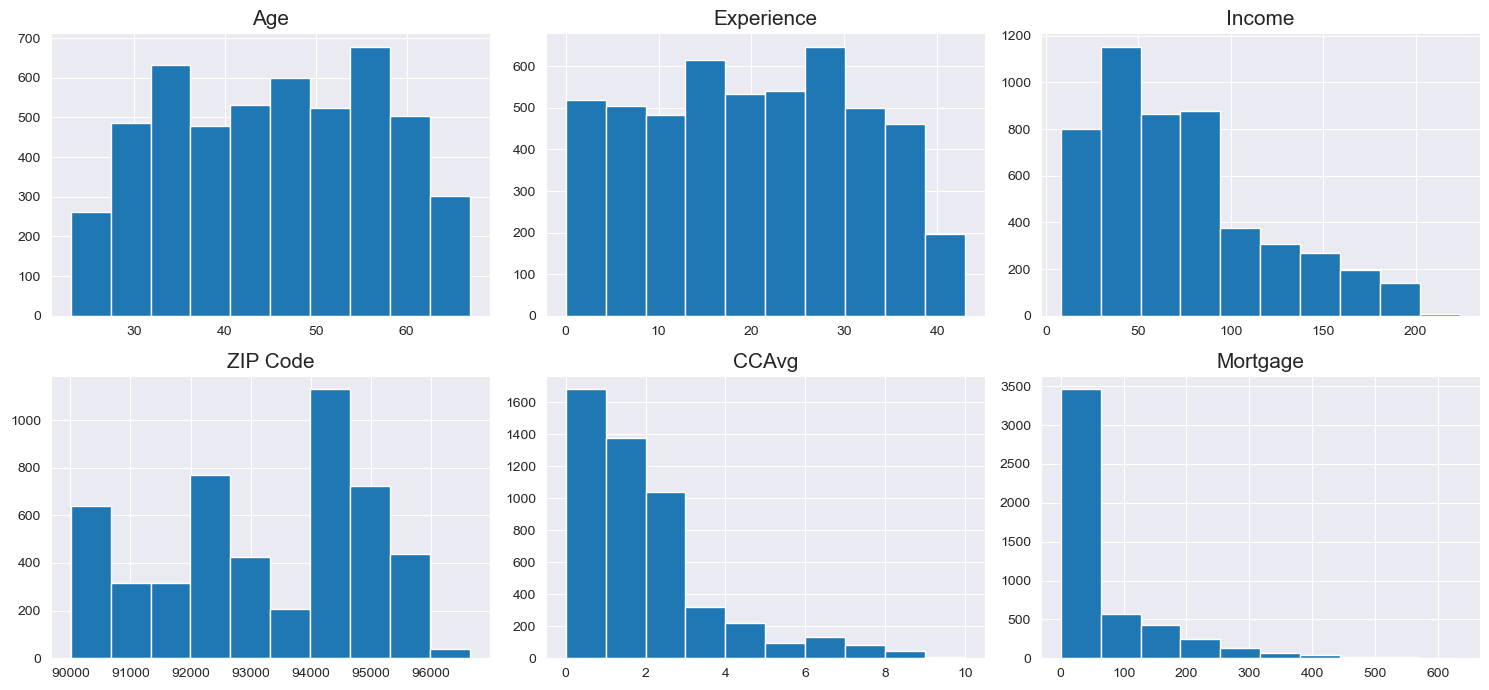

In [274]:
num_col=['Age','Experience','Income','ZIP Code','CCAvg','Mortgage']

n_rows = math.ceil(len(num_col)/3)
plt.figure(figsize=(15, n_rows*3.5))
for i, num_col in enumerate(list(num_col)):
    plt.subplot(n_rows, 3, i+1)
    plt.hist(df[num_col])
    plt.tight_layout()
    plt.title(num_col, fontsize=15);

In [275]:
df.drop(['ID_Customer'], axis=1, inplace=True)
df.columns

Index(['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4999 non-null   int64  
 1   Experience          4999 non-null   int64  
 2   Income              4999 non-null   int64  
 3   ZIP Code            4999 non-null   int64  
 4   Family              4999 non-null   int64  
 5   CCAvg               4999 non-null   float64
 6   Education           4999 non-null   int64  
 7   Mortgage            4999 non-null   int64  
 8   Personal Loan       4999 non-null   int64  
 9   Securities Account  4999 non-null   int64  
 10  CD Account          4999 non-null   int64  
 11  Online              4999 non-null   int64  
 12  CreditCard          4999 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.8 KB


In [277]:
df['Personal Loan'].value_counts()

0    4519
1     480
Name: Personal Loan, dtype: int64

In [278]:
df1 = pd.get_dummies(df, columns=['Education', 'Family'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4999 non-null   int64  
 1   Experience          4999 non-null   int64  
 2   Income              4999 non-null   int64  
 3   ZIP Code            4999 non-null   int64  
 4   CCAvg               4999 non-null   float64
 5   Mortgage            4999 non-null   int64  
 6   Personal Loan       4999 non-null   int64  
 7   Securities Account  4999 non-null   int64  
 8   CD Account          4999 non-null   int64  
 9   Online              4999 non-null   int64  
 10  CreditCard          4999 non-null   int64  
 11  Education_1         4999 non-null   uint8  
 12  Education_2         4999 non-null   uint8  
 13  Education_3         4999 non-null   uint8  
 14  Family_1            4999 non-null   uint8  
 15  Family_2            4999 non-null   uint8  
 16  Family

In [279]:
y=df1.pop('Personal Loan')
X=df1

X.shape

(4999, 17)

In [280]:

X.shape, y.shape

((4999, 17), (4999,))

In [337]:
# scaler = StandardScaler()
# scaler.fit(X_num)
# X_scaled = scaler.transform(X_num)
# X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns=X_num.columns)
# X_scaled = pd.concat([X_scaled, X_cat], axis=1)
# y_scaled = y

nm=NearMiss()
X_scaled, y_scaled = nm.fit_resample(X, y)
X_scaled, y_scaled = nm.fit_resample(X_scaled, y_scaled)
X_scaled.head()

,Age,Experience,Income,ZIP Code,CCAvg,Mortgage,Securities Account,CD Account,Online,CreditCard,Education_1,Education_2,Education_3,Family_1,Family_2,Family_3,Family_4
0,41,16,118,94720,3.30,0,0,0,1,0,1,0,0,0,1,0,0
1,39,14,113,94301,1.00,0,1,0,1,0,0,0,1,1,0,0,0
2,32,8,128,94720,4.33,0,0,1,1,1,1,0,0,0,1,0,0
3,40,16,115,94305,3.40,0,0,0,1,0,1,0,0,1,0,0,0
4,41,17,129,94720,3.40,0,0,0,0,1,1,0,0,1,0,0,0


In [338]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [339]:
X_train.shape, y_test.shape, y_train.value_counts(), y_test.value_counts()

((3499, 17),
 (1500,),
 0    3167
 1     332
 Name: Personal Loan, dtype: int64,
 0    1352
 1     148
 Name: Personal Loan, dtype: int64)

# Decision Tree

In [340]:
model_dt = DecisionTreeClassifier()
param_dt = {
    'criterion':['gini','entropy'],
    'min_samples_split':[2,5,10,15],
    'max_depth':[None, 1,3,5, 7 ,9],
    'min_samples_leaf':[None, 1,3,10,15],
    'max_features':[None,'sqrt','log2']
}

In [341]:
GSDT1 = GridSearchCV(model_dt, param_dt, cv=5, scoring='accuracy', n_jobs=n_thread)
GSDT1.fit(X_train, y_train)
print('best_param:', GSDT1.best_params_)
print('best_score:', GSDT1.best_score_)

best_param: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_score: 0.9837097894951972


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/Users/davis901

In [342]:
pred_dt = GSDT1.predict(X_test)
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1352
           1       0.98      0.90      0.94       148

    accuracy                           0.99      1500
   macro avg       0.98      0.95      0.96      1500
weighted avg       0.99      0.99      0.99      1500


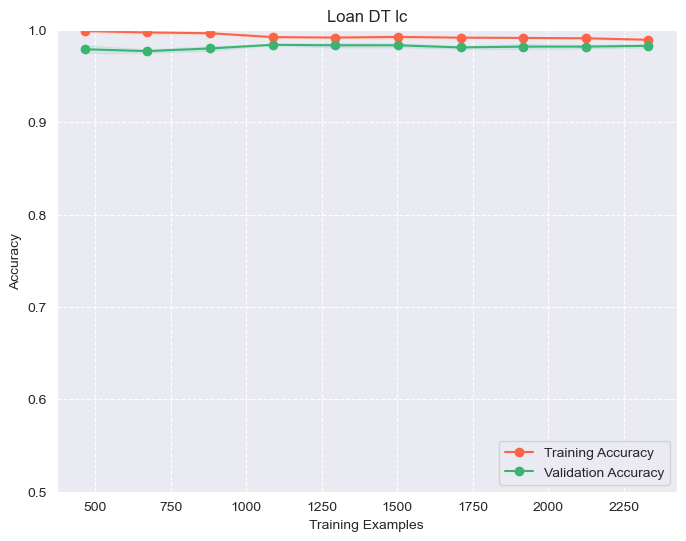

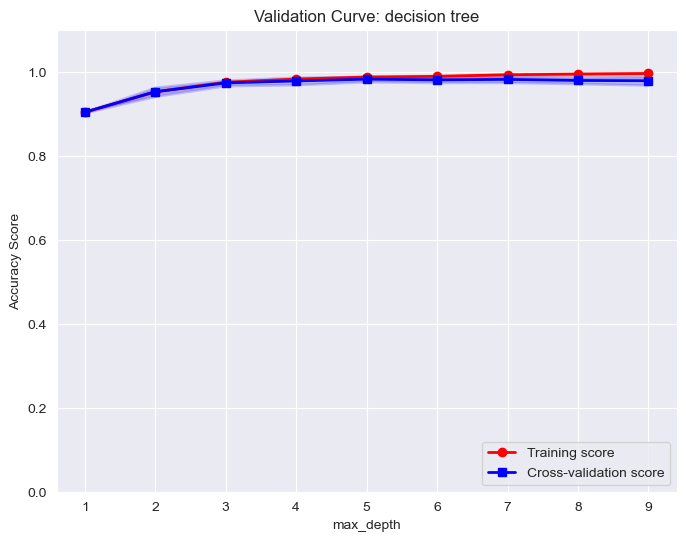

In [343]:

plot_learning_curve(GSDT1.best_estimator_, "Loan DT lc", X_train, y_train, score_limits=(0.5,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSDT1.best_estimator_, "decision tree")

# SVM


In [344]:
model_svm = LinearSVC(class_weight='balanced')
param_svm = {
    'penalty': ['l1', 'l2'],  
    'loss': ['hinge', 'squared_hinge'],  
    'C': [0.01, 0.1, 1, 10,70,100],  

}

In [345]:
GSSVM1 = GridSearchCV(model_svm, param_svm, cv=5, scoring='accuracy', n_jobs=n_thread)
GSSVM1.fit(X_train, y_train)
print('best_param:', GSSVM1.best_params_)
print('best_score:', GSSVM1.best_score_)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244

best_param: {'C': 0.1, 'loss': 'hinge', 'penalty': 'l2'}
best_score: 0.9051158798283263


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [346]:
pred_svm = GSSVM1.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1352
           1       0.00      0.00      0.00       148

    accuracy                           0.90      1500
   macro avg       0.45      0.50      0.47      1500
weighted avg       0.81      0.90      0.85      1500


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244

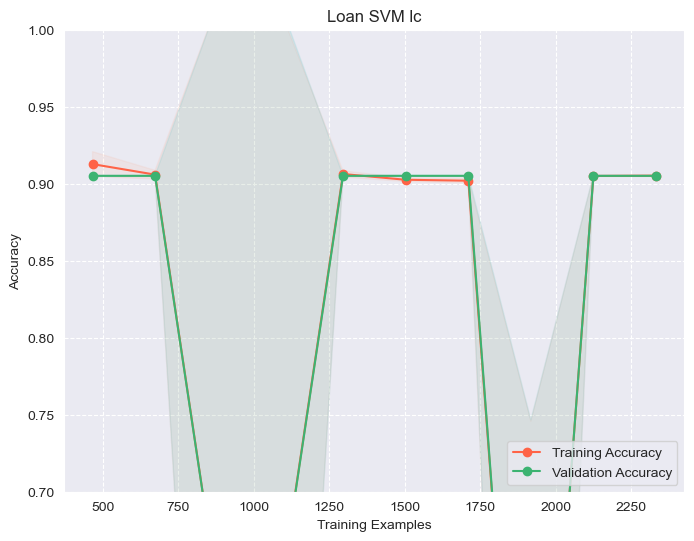

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244

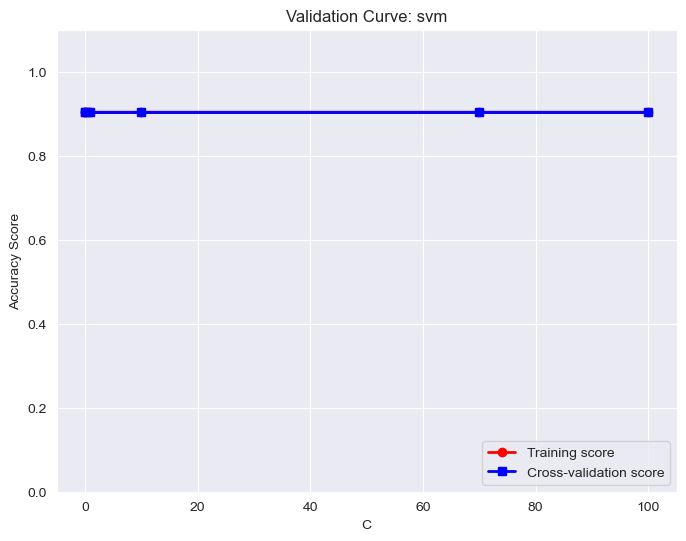

In [347]:
plot_learning_curve(GSSVM1.best_estimator_, "Loan SVM lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSSVM1.best_estimator_, "svm")

In [348]:
model_svc = SVC()
param_svc = {
     'C': [0.01, 0.1, 1, 10, 70,100],  
    'gamma': [0.001,0.01, 0.1, 1, 10,100],  
    'kernel': ['rbf'],
 
    'max_iter': [500, 1000, 2000]
}

In [349]:
GSSVM2 = GridSearchCV(model_svc, param_svc, cv=5, scoring='accuracy', n_jobs=n_thread)
GSSVM2.fit(X_train, y_train)
print('best_param:', GSSVM2.best_params_)
print('best_score:', GSSVM2.best_score_)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299:

best_param: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 500}
best_score: 0.9056873083997548


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [350]:
pred_svm2 = GSSVM2.predict(X_test)
print(classification_report(y_test, pred_svm2))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1352
           1       0.00      0.00      0.00       148

    accuracy                           0.90      1500
   macro avg       0.45      0.50      0.47      1500
weighted avg       0.81      0.90      0.85      1500


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299:

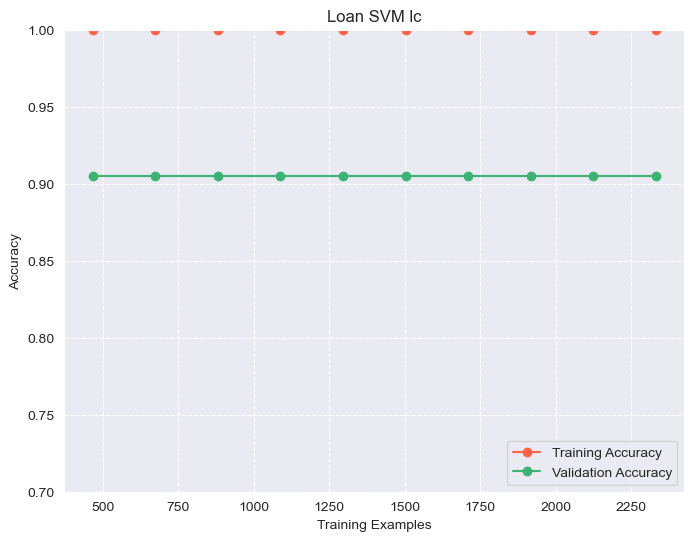

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299:

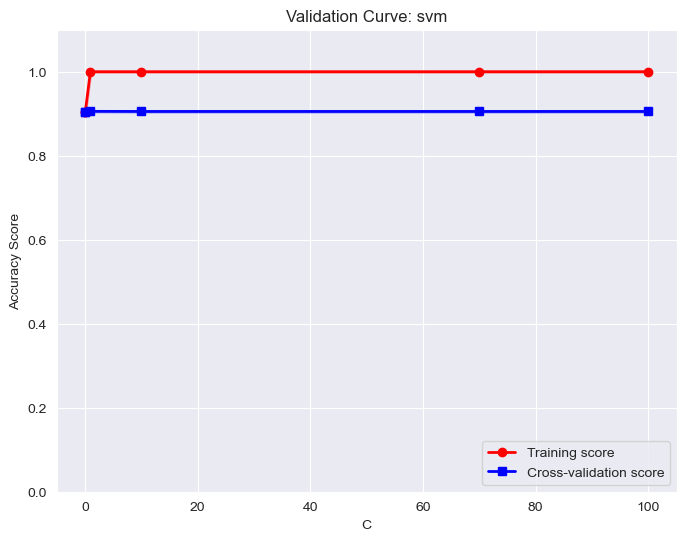

In [351]:
plot_learning_curve(GSSVM2.best_estimator_, "Loan SVM lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSSVM2.best_estimator_, "svm")

# KNN

In [352]:
model_knn = KNeighborsClassifier()
param_knn = {
    'n_neighbors': [1,2, 3, 4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20],  
    'weights': ['uniform', 'distance'],  
    'algorithm': ['auto'], 
}

In [353]:
GSKNN1 = GridSearchCV(model_knn, param_knn, cv=5, scoring='accuracy', n_jobs=n_thread)
GSKNN1.fit(X_train, y_train)
print('best_param:', GSKNN1.best_params_)
print('best_score:', GSKNN1.best_score_)

best_param: {'algorithm': 'auto', 'n_neighbors': 19, 'weights': 'uniform'}
best_score: 0.906259554465563


In [354]:
pred_knn = GSKNN1.predict(X_test)
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      1352
           1       0.25      0.02      0.04       148

    accuracy                           0.90      1500
   macro avg       0.58      0.51      0.49      1500
weighted avg       0.84      0.90      0.86      1500


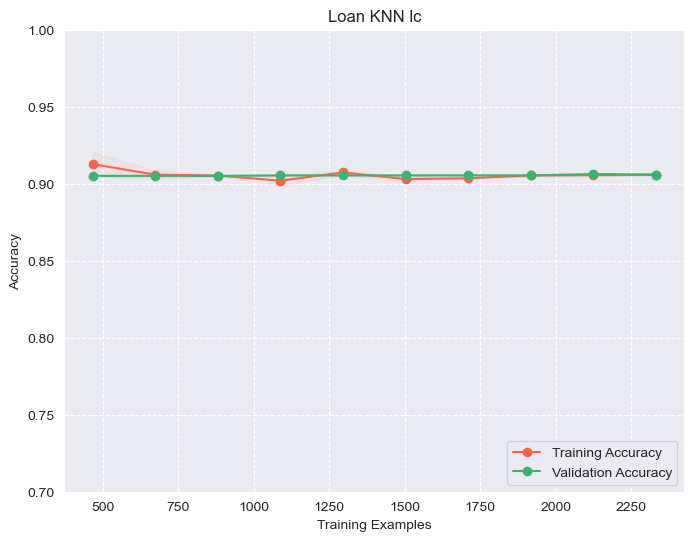

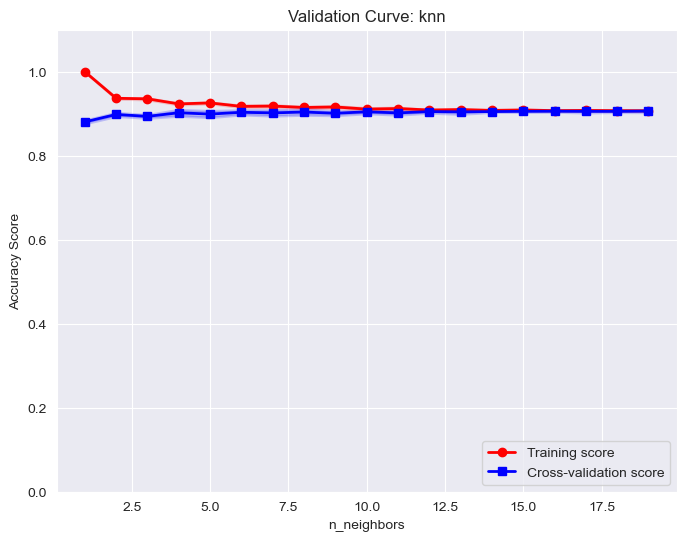

In [355]:
plot_learning_curve(GSKNN1.best_estimator_, "Loan KNN lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSKNN1.best_estimator_, "knn")

# Neural Net

In [356]:
model_nn = MLPClassifier(max_iter=7000, learning_rate='adaptive')
param_nn = {
	'alpha': [1e-03,1e-02,1e-01,1,2,3],
	'learning_rate_init': [0.00001,0.0001,0.001,0.01,0.1,1],
	'activation': ['tanh', 'relu']
}

In [357]:
GSNN = GridSearchCV(model_nn, param_nn, cv=5, scoring='accuracy', n_jobs=n_thread)
GSNN.fit(X_train, y_train)
print('best_param:', GSNN.best_params_)
print('best_score:', GSNN.best_score_)

best_param: {'activation': 'relu', 'alpha': 2, 'learning_rate_init': 1e-05}
best_score: 0.9122607807071326


In [358]:
pred_nn = GSNN.predict(X_test)
print(classification_report(y_test, pred_nn))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95      1352
           1       0.44      0.05      0.09       148

    accuracy                           0.90      1500
   macro avg       0.67      0.52      0.52      1500
weighted avg       0.86      0.90      0.86      1500


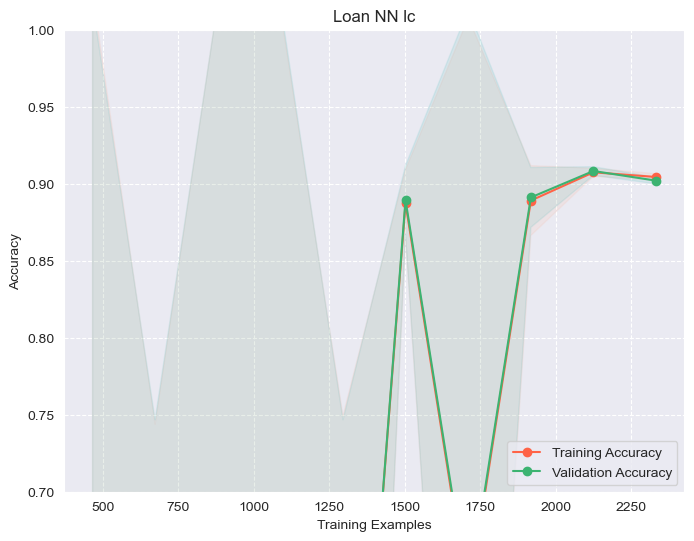

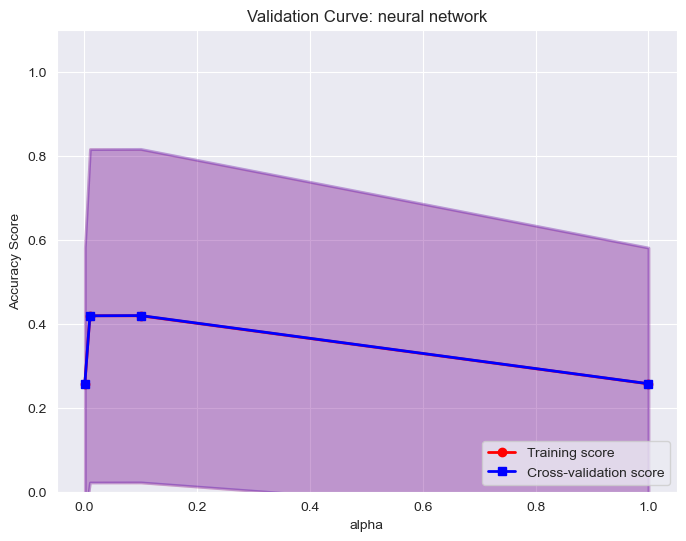

In [359]:
plot_learning_curve(GSNN.best_estimator_, "Loan NN lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSNN.best_estimator_, "neural network")

#  Boosted Decision Tree

In [360]:
model_bdt = AdaBoostClassifier()
best_est_dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, min_samples_split=2)
param_bdt = {
	'base_estimator': [GSDT1.best_estimator_,best_est_dt],
     'n_estimators': [50,70,90,110,130,150,170,190,200], 
    'learning_rate': [0.0001,0.001,0.01, 0.1, 1.0],  

}

In [361]:
GSBDT = GridSearchCV(model_bdt, param_bdt, cv=5, scoring='accuracy', n_jobs=n_thread)
GSBDT.fit(X_train, y_train)
print('best_param:', GSBDT.best_params_)
print('best_score:', GSBDT.best_score_)

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed 

best_param: {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5), 'learning_rate': 1.0, 'n_estimators': 70}
best_score: 0.9868550991211935


In [362]:
pred_bdt = GSBDT.predict(X_test)
print(classification_report(y_test, pred_bdt))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1352
           1       0.97      0.87      0.92       148

    accuracy                           0.98      1500
   macro avg       0.98      0.93      0.95      1500
weighted avg       0.98      0.98      0.98      1500


/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed 

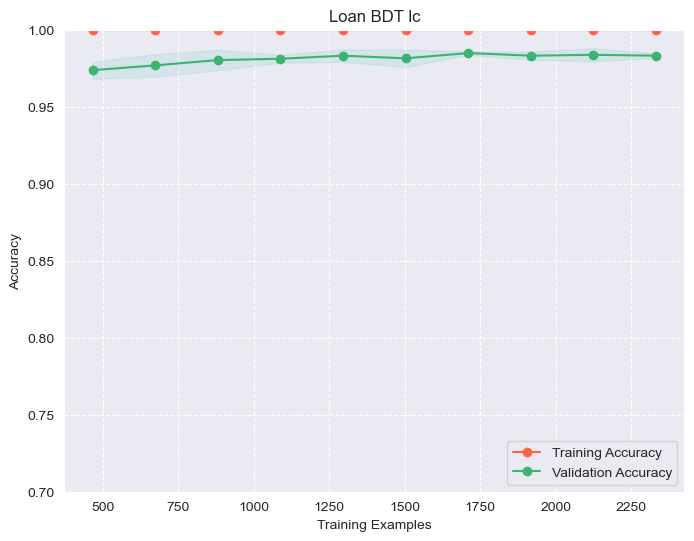

/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/davis901/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed 

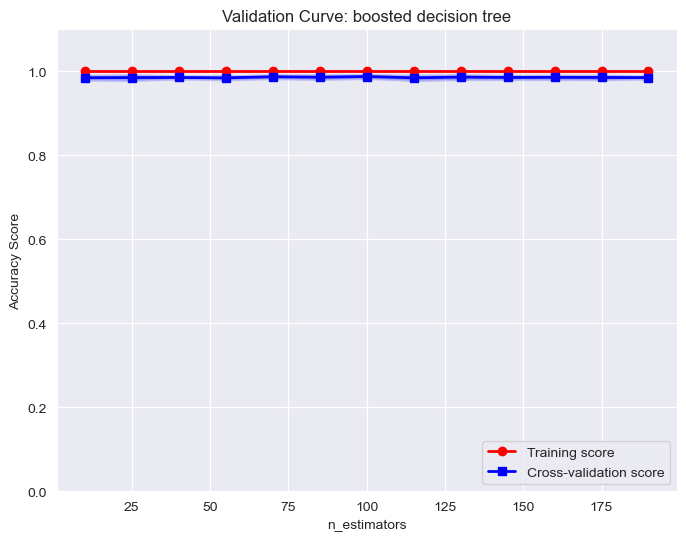

In [363]:
plot_learning_curve(GSBDT.best_estimator_, "Loan BDT lc", X_train, y_train, score_limits=(0.7,1.0), cross_val_method=3, n_jobs=n_thread, data_points=np.linspace(0.2,1.0,10))
plot_validation_curve(X_train, y_train, GSBDT.best_estimator_, "boosted decision tree")

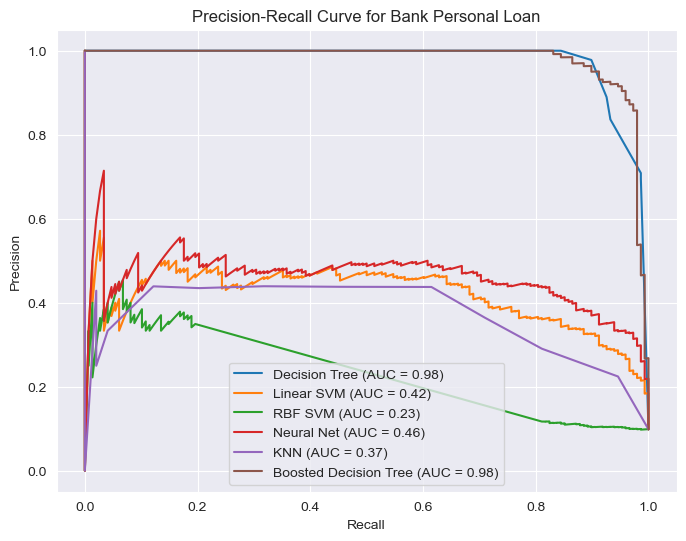

In [366]:
# Assuming GSRL1, GSDT1, GSRF1, and GS_LGB1 are your trained GridSearchCV objects for different models
models = [
    ('Decision Tree', GSDT1.best_estimator_),
    ('Linear SVM', GSSVM1.best_estimator_),
    ('RBF SVM', GSSVM2.best_estimator_),
    ('Neural Net', GSNN.best_estimator_),
    ('KNN', GSKNN1.best_estimator_),
    ('Boosted Decision Tree', GSBDT.best_estimator_)
]

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

for name, model in models:
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        y_scores = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    
    ax.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve for Bank Personal Loan')
ax.legend(loc='best')
plt.show()